In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install transformers

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 3.3MB 52.0MB/s 
     |████████████████████████████████| 901kB 44.9MB/s 


In [3]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

In [4]:
def encode_dataframe(statement_col, target_col, unpack=False):
    # Tokenize statements
    bert_encoded_dict = statement_col.apply(lambda sent: bert_tokenizer.encode_plus(
                                      sent,                      # Sentence to encode.
                                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                      max_length = 120,           # Pad & truncate all sentences.
                                      pad_to_max_length = True,
                                      return_attention_mask = True,   # Construct attn. masks.
                                      return_tensors = 'pt',     # Return pytorch tensors.
                                      truncation = True
                                ))
    bert_input_ids = torch.cat([item['input_ids'] for item in bert_encoded_dict], dim=0)
    bert_attention_masks = torch.cat([item['attention_mask'] for item in bert_encoded_dict], dim=0)

    # Format targets
    labels = torch.tensor(target_col)
    sentence_ids = torch.tensor(range(len(target_col)))

    # Combine the training inputs into a TensorDataset
    bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)

    # Remove indices
    trial_dataset =  index_remover(bert_dataset)

    if unpack:
        return bert_input_ids, bert_attention_masks, labels
    else:
        return trial_dataset

def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [5]:
import torch.nn as nn
from transformers import AutoModel
class FakeBERT(nn.Module):
    def __init__(self):
        super(FakeBERT, self).__init__()
        
        self.base_model = AutoModel.from_pretrained('bert-base-uncased')

        # Layer 1: Conv1D + Maxpool
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
        self.sigm_1 = nn.ReLU()
        self.pool_1 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 6: Fully Connected Layer 
        self.full_6 = nn.Linear(153,32)
        self.sigm_6 = nn.Sigmoid()
        
        # Layer 7: Fully Connected Layer 
        self.full_7 = nn.Linear(32,2)
        self.soft_7 = nn.Softmax()

    def forward(self, input_ids, attn_mask):
        bert_output = self.base_model(input_ids, attention_mask=attn_mask)
        outputs = self.pool_1(self.sigm_1(self.conv_1(bert_output['pooler_output'].unsqueeze(1))))
        outputs = self.sigm_6(self.full_6(outputs))
        outputs = self.soft_7(self.full_7(outputs))
        return outputs, bert_output

In [6]:
# Device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Model
bert_model = torch.load("/content/drive/MyDrive/fake-news-explainability/Models/bert_model_fake_news_kaggle_full", map_location=device)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

## Test on Negated Inputs

In [26]:
df_positive = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/fake_news_positive.csv")
df_negative = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/fake_news_negative.csv")

In [12]:
# Load in Fake News Positive/Negative
df_positive = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/fake_news_positive.csv")
df_negative = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/fake_news_negative.csv")
df_positive['target'] = df_positive['label']
df_negative['target'] = df_negative['label']
df_pos_encode = encode_dataframe(df_positive['text'], df_positive['target'])
df_neg_encode = encode_dataframe(df_negative['text'], df_negative['target'])
torch.save(df_pos_encode,
           "/content/drive/MyDrive/fake-news-explainability/fake_news_pos_encoded.pt")
torch.save(df_neg_encode,
           "/content/drive/MyDrive/fake-news-explainability/fake_news_neg_encoded.pt")

# Load in from saved encoded
# df_pos_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/fake_news_pos_encoded.pt")
# df_neg_encode = torch.load("/content/drive/MyDrive/fake-news-explainability/fake_news_neg_encoded.pt")

In [13]:
# Load data into dataloader
batch_size = 1000
bert_pos_dataloader = DataLoader(df_pos_encode, batch_size = batch_size)
bert_neg_dataloader = DataLoader(df_neg_encode, batch_size = batch_size)

# Run the inputs through the model
outputs_pos = []
outputs_neg = []
with torch.no_grad():
    for step, batch in enumerate(bert_pos_dataloader):
        # Unpack batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)       

        # Forward pass
        output = bert_model(b_input_ids, b_input_mask)
        outputs_pos.append(output[0])
    
    for step, batch in enumerate(bert_neg_dataloader):
        # Unpack batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)       

        # Forward pass
        output = bert_model(b_input_ids, b_input_mask)
        outputs_neg.append(output[0])
  
# Stack outputs
outputs_pos = torch.vstack(outputs_pos).squeeze(1)
outputs_neg = torch.vstack(outputs_neg).squeeze(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [23]:
# Original LIAR accuracy
print(f"Original LIAR Acc: {flat_accuracy(outputs_pos.detach().cpu().numpy(), df_pos_encode.tensors[2].to('cpu').numpy())}")

# Negated LIAR accuracy
print(f"Negated LIAR Acc: {flat_accuracy(outputs_neg.detach().cpu().numpy(), df_neg_encode.tensors[2].to('cpu').numpy())}")

Original LIAR Acc: 0.991346701901653
Negated LIAR Acc: 0.9903621949323799


(array([1.8539e+04, 2.2400e+02, 9.1000e+01, 6.6000e+01, 5.1000e+01,
        3.5000e+01, 3.0000e+01, 2.9000e+01, 1.5000e+01, 2.3000e+01,
        1.2000e+01, 1.5000e+01, 1.3000e+01, 4.0000e+00, 5.0000e+00,
        6.0000e+00, 8.0000e+00, 1.0000e+01, 1.1000e+01, 1.2000e+01,
        3.4000e+01, 2.4000e+01, 2.3000e+01, 6.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.7093484e-08, 7.8447665e-05, 1.5687823e-04, 2.3530881e-04,
        3.1373938e-04, 3.9216995e-04, 4.7060053e-04, 5.4903107e-04,
        6.2746165e-04, 7.0589222e-04, 7.843227

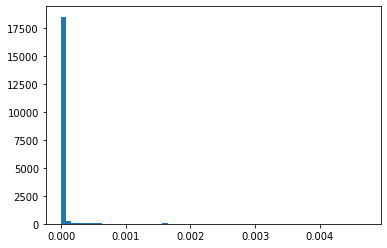

In [24]:
# Difference between predictions
import matplotlib.pyplot as plt
mse = torch.norm(outputs_pos-outputs_neg, 2, dim=1)
plt.hist(mse.cpu(), bins=60)

In [28]:
for i in torch.where(mse>0.001)[0].cpu():
    print(df_positive['text'][int(i)])
    print(df_negative['text'][int(i)])
    print('\n')

  Now, numerous studies have concluded that milk doesn’t actually build bone and provide the same amount of calcium that we thought. A study published in the British Medical Journal , for example, followed more than 100,000 people in Sweden over periods of 20 to 30 years, with shocking results: The people who drank milk were more likely to die from heart disease and cancer. The women suffered more overall fractures and hip fractures as well. Different studies have also shown that higher dairy intake is linked to higher risks of prostate and ovarian cancer and can trigger type 1 diabetes. It is also linked to forms of acne, just to name a few effects. There is also the disturbing side of the dairy industry, where animals are abused to produce the milk we drink. A lot of dairy products are filled with the hormones that were given to female cows to keep them perpetually lactating so they produce an endless flow of milk. This doctor describes it perfectly when he says “cow’s milk is for ba

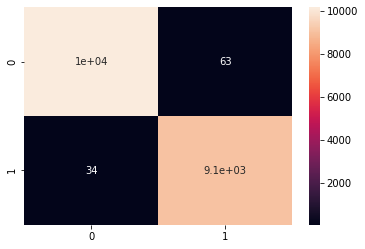

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(torch.argmax(outputs_pos.cpu(), axis=1), 
                             torch.argmax(outputs_neg.cpu(), axis=1))
sns.heatmap(cf_matrix, annot=True)